In [212]:
import shutil

import pandas as pd
from fastai.vision.all import *
from sklearn.model_selection import train_test_split
import cv2
import seaborn as sns

## Split data 

In [140]:
dataset_df = pd.DataFrame()

In [141]:
for filename in os.listdir('dataset_v2/up'):
    dataset_df = pd.concat([dataset_df, pd.DataFrame([{'filename': filename, 'label': 'up'}])], ignore_index=True)
    
for filename in os.listdir('dataset_v2/run'):
    dataset_df = pd.concat([dataset_df, pd.DataFrame([{'filename': filename, 'label': 'run'}])], ignore_index=True) 

In [142]:
dataset_df

,filename,label
0,04-30-2022-23-18-29-803645.png,up
1,04-30-2022-23-18-31-118991.png,up
2,04-30-2022-23-18-32-400945.png,up
3,04-30-2022-23-18-33-705966.png,up
4,04-30-2022-23-18-34-972686.png,up
...,...,...
2035,04-30-2022-23-33-22-216411.png,run
2036,04-30-2022-23-33-22-309455.png,run
2037,04-30-2022-23-33-22-325456.png,run
2038,04-30-2022-23-33-22-341282.png,run


In [145]:
train, test = train_test_split(dataset_df, test_size=0.20, random_state=14)

In [146]:
train.groupby('label').size()

label
run    1229
up      403
dtype: int64

In [147]:
test.groupby('label').size()

label
run    307
up     101
dtype: int64

In [149]:
def copy_image_into_folder(is_train, label, file_name):
    target = 'test'
    if is_train:
        target = 'train'
        
    original_path = 'dataset_v2\\'
    shutil.copyfile(os.path.join(os.getcwd(), f'{original_path}{label}\\{filename}'), 
                    os.path.join(os.getcwd(), f'.\\{target}\\{label}\\{filename}'))

In [150]:
train.apply(lambda x: copy_image_into_folder(True, x['label'], x['filename']), axis=1)

1779    None
545     None
620     None
1204    None
933     None
        ... 
327     None
406     None
1292    None
1368    None
619     None
Length: 1632, dtype: object

In [151]:
test.apply(lambda x: copy_image_into_folder(False, x['label'], x['filename']), axis=1)

1820    None
1355    None
1921    None
1025    None
951     None
        ... 
212     None
16      None
496     None
75      None
1327    None
Length: 408, dtype: object

## Training Model

In [152]:
path = 'train'
fnames = get_image_files(path)
def label_func(x): return x.parent.name

In [153]:
dls = ImageDataLoaders.from_path_func(path, fnames, label_func, number_workers=0)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [154]:
len(dls[1])

6

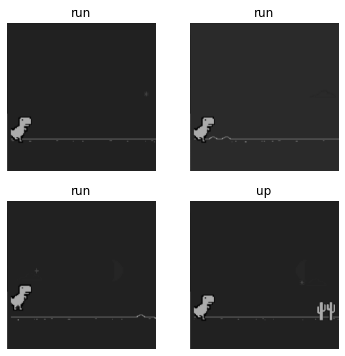

In [155]:
dls.valid.show_batch(max_n=4, nrows=2)

last image is caused by game background transition

In [156]:
learn = cnn_learner(dls, resnet18, metrics=[error_rate, accuracy])

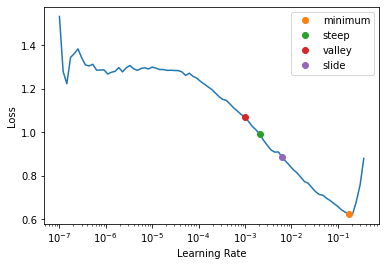

In [6]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [157]:
%%time
learn.fine_tune(2, base_lr=10e-03)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.535624,1.757589,0.438650,0.561350,01:20


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.125842,0.199349,0.021472,0.978528,01:39
1,0.094753,0.099564,0.018405,0.981595,01:39


CPU times: total: 27min 45s
Wall time: 4min 39s


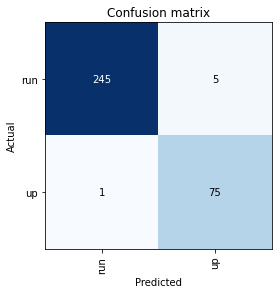

In [158]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [159]:
interp.print_classification_report()

              precision    recall  f1-score   support

         run       1.00      0.98      0.99       250
          up       0.94      0.99      0.96        76

    accuracy                           0.98       326
   macro avg       0.97      0.98      0.97       326
weighted avg       0.98      0.98      0.98       326



In [160]:
learn.export(os.path.abspath('models/v7.pkl'))

## Test Model

In [185]:
test_df = pd.DataFrame()

In [189]:
for filename in os.listdir('test/up'):
    test_df = pd.concat([test_df, pd.DataFrame([{'filename': filename, 'label': 'up'}])], ignore_index=True)
    
for filename in os.listdir('test/run'):
    test_df = pd.concat([test_df, pd.DataFrame([{'filename': filename, 'label': 'run'}])], ignore_index=True)

In [190]:
def predict(filename, label):
    image = cv2.imread(f'test/{label}/{filename}')
    return learn.predict(image)[0]

In [194]:
%%capture
test_df['predict'] = test_df.apply(lambda x: predict(x['filename'], x['label']), axis=1);

In [197]:
test_df['correct'] = test_df.apply(lambda x: 1 if x['label']==x['predict'] else 0, axis=1)

In [201]:
accuracy = test_df['correct'].sum()/len(test_df)*100

In [205]:
print(f'Accuracy of test set is: {accuracy}')

Accuracy of test set is: 98.77450980392157


In [209]:
true_positive = 0
false_positive = 0
true_negative = 0
false_negative = 0

for index, row in test_df.iterrows():
    if row['label'] == 'up':
        if row['predict'] == 'up':
            true_positive += 1
        else:
            false_negative += 1
    else:
        if row['predict'] == 'up':
            false_positive += 1
        else:
            true_negative += 1

<AxesSubplot:>

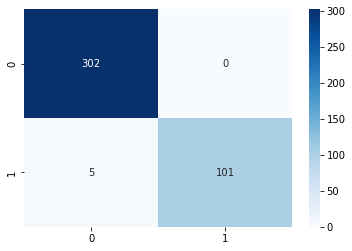

In [224]:
sns.heatmap([[true_negative, false_negative], [false_positive, true_positive]], cmap='Blues', annot=True, fmt='g')